In [5]:
import sys
sys.path.append('/home/disk/p/jkcm/Code')
import xarray as xr
import numpy as np
from itertools import product, cycle
from functools import reduce
import os
from matplotlib import cm
from Lagrangian_CSET.LoopTimer import LoopTimer
from random import sample
import pandas as pd
import glob
import pickle
import matplotlib.pyplot as plt

from utils import nan_correlate
from process_correlations import get_dataset, quick_regrid

%load_ext autoreload
%autoreload 2

In [6]:
all_sep_df = pd.DataFrame()
for year in ['2014', '2015', '2016']:
    savefile = f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/old/sep_with_clim_ceres_merra_{year}_modified3.pickle'
    temp_df = pickle.load(open(savefile, 'rb'))
    all_sep_df = pd.concat([all_sep_df, temp_df], ignore_index=True)
true_sep = all_sep_df[all_sep_df.lat<0]
best_sep_df = true_sep[true_sep.lat>-40]

In [5]:
MERRA_data = xr.open_dataset(r'/home/disk/eos4/jkcm/Data/MERRA/measures/MERRA_unified_subset_SEP.nc', lock=False)

In [ ]:
EIS_rg = MERRA_data.EIS.isel(lat=slice(None,None,2),lon=slice(None,None,2),time=slice(None,None,8))

In [47]:
if True: # for all vars, or func def
    var = 'EIS'
    daily_data = MERRA_data[var].isel(time=slice(None,None,8))
#     if True: # for all dims
    for dim in daily_data.dims:
#         dim = 'time'
        savename = (f'/home/disk/eos4/jkcm/Data/MEASURES/correlations/lag_correlations.{var}.{dim}.nc')
        remaining_dims = [i for i in daily_data.dims if not i==dim]
        dim_axis = daily_data.dims.index(dim)
        other_axes = [i for i in np.arange(len(daily_data.dims)) if not i==dim_axis]
        ax_iters = [daily_data[i].values for i in remaining_dims]
        empties = np.full([daily_data.shape[i] for i in other_axes], np.nan)
        all_lags = np.arange(20)
        end_result = daily_data.isel({dim: 0}).copy(data=empties).expand_dims(lag=all_lags)
#         if True: # for all lags
        for lag in all_lags:
#             lag = 5
#             empties = np.full([daily_data.shape[i] for i in other_axes], np.nan)
#             end_result = daily_data.isel({dim: 0}).copy(data=empties)
            a = daily_data.isel({dim:slice(lag,None,lag)})
            a_shift = daily_data.isel({dim:slice(None,-lag,lag)})
            lt = LoopTimer(reduce((lambda x, y: x * y), empties.shape))
            for i in product(*[l for l in ax_iters]):
                lt.update()
                x = {rd: n for rd, n in zip(remaining_dims,i)}
                a_sl = a.sel(x).values
                a_shift_sl = a_shift.sel(x).values
                corr = nan_correlate(a_sl, a_shift_sl)
                x['lag'] = lag
                end_result.loc[x] = corr
        end_result.to_netcdf(savename)
#                 print(a_sl.shape, a_shift_sl.shape)
#                 print(i)
#             for ax in other_axes:
                
            #for every axis in other_axes: 
                #make an iterator
                
            #do some fuckin magic
            


100.00%      ETA 14:44:32      time left: 0 seconds                                                                                                                                                                          

In [ ]:
lat_lags = []
lon_lags = []
t_lags = []
var = 'EIS'

for di in range(1,2):#, 30):
    print(di)
    for i, (dim, arr) in enumerate(zip(['lat', 'lon', 'time'], [lat_lags, lon_lags, t_lags])):
        a = daily_data.isel({dim:slice(di,None,di)}).values
        a_shift = daily_data.isel({dim:slice(None,-di,di)}).values
        arr.append(nan_correlate(a.flatten(), a_shift.flatten()))

In [21]:
data_lon = xr.open_mfdataset(glob.glob(r'/home/disk/eos4/jkcm/Data/MEASURES/correlations/lag_correlations.*.lon.nc'), combine='by_coords', compat='override')
data_time = xr.open_mfdataset(glob.glob(r'/home/disk/eos4/jkcm/Data/MEASURES/correlations/lag_correlations.*.time.nc'), combine='by_coords', compat='override')
data_lat = xr.open_mfdataset(glob.glob(r'/home/disk/eos4/jkcm/Data/MEASURES/correlations/lag_correlations.*.lat.nc'), combine='by_coords', compat='override')

In [38]:
files = glob.glob(r'/home/disk/eos4/jkcm/Data/MEASURES/correlations/lag_correlations.*.time.nc')
files = [f for f in files if not 'vapor' in f]
files = [f for f in files if not 'net_cre' in f]
files = [f for f in files if not 'cld' in f]

data_time = xr.open_mfdataset(files, combine='by_coords')

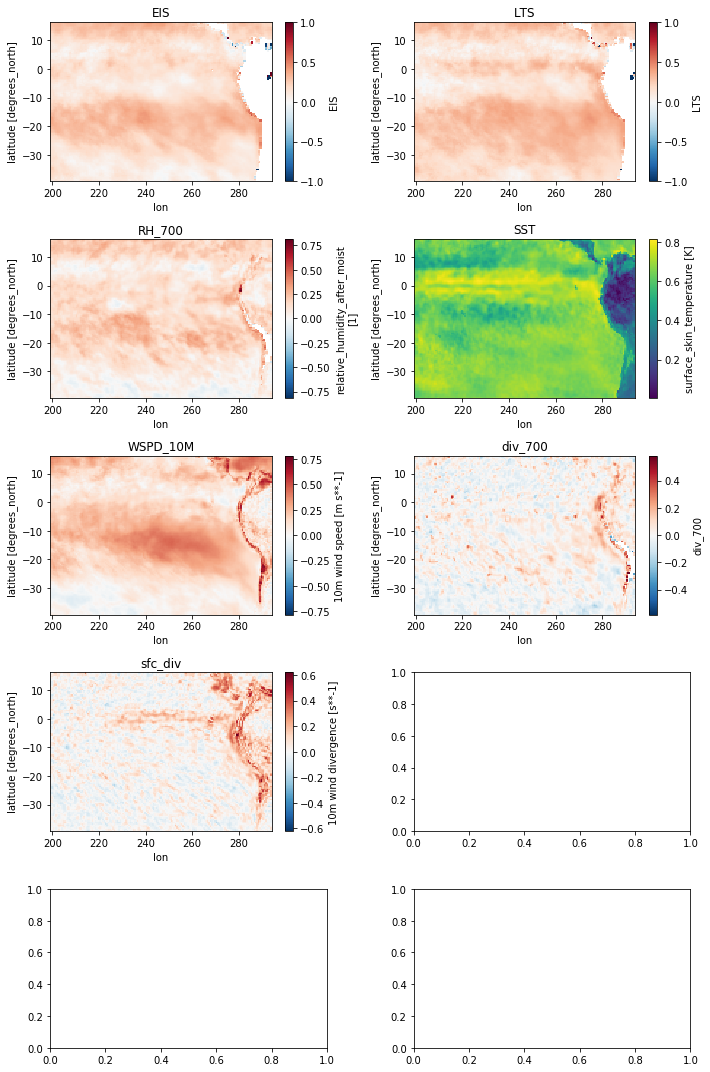

In [39]:
fig, ax = plt.subplots(figsize=(10, 15), nrows=5, ncols=2)
axl = ax.flatten()
for i, var in enumerate(data_time.data_vars.keys()):
    data_time[var].isel(lag=1).plot(ax=axl[i])
#     axl[i].set_ylim([-40, 0])
#     axl[i].set_xlim([200,300])
    axl[i].set_title(var)
plt.tight_layout()

In [8]:
files = glob.glob('/home/disk/eos4/jkcm/Data/MEASURES/correlations/lag_correlations.*.nc')
file_dims = [os.path.basename(f).split('.')[2] for f in files]
file_vars = [os.path.basename(f).split('.')[1] for f in files]
all_vars = list(set(file_vars))
colors = [cm.get_cmap('rainbow')(i) for i in np.linspace(0,1,len(all_vars))]
opts = cycle(['-', '--'])
styles = [next(opts) for i in range(len(colors))]
decorr_scale = {}
spacings = {}
for f, d, v in zip(files, file_dims, file_vars):
    data = xr.open_dataset(f)
    for newdim in [i for i in data.dims if not i in ['lag', v]]:
        diff = np.mean(np.diff(data[newdim].values))
        if type(diff)==np.timedelta64:
            diff = diff/np.timedelta64(1, 'D')
        spacings.setdefault(v, {})[newdim] = diff
    mean_d = data[v].mean(dim=[i for i in data.dims if not i=='lag'])
    crossings = list(np.where(mean_d<(1/np.e))[0]) + [len(mean_d)] # if no crossing, pick last one
#     print(crossings)
    decorr_scale.setdefault(v, {})[d] = crossings[0]+1 # add one because at index 0, it's lag 1

Text(0.5, 6.79999999999999, 'lag ($^{\\circ}$ lon)')

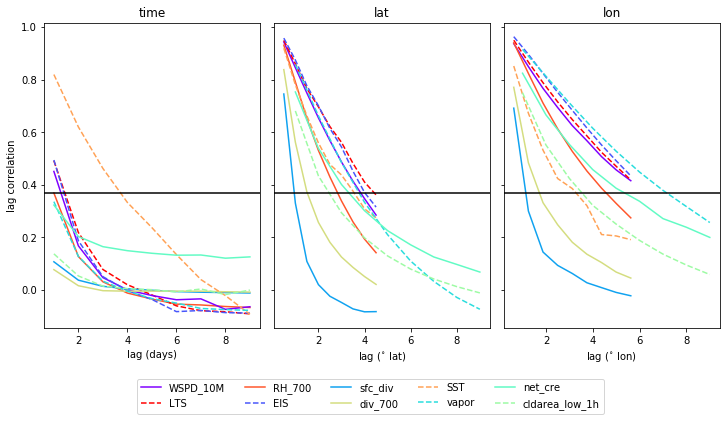

In [9]:
fig, ax = plt.subplots(figsize=(10,5), ncols=3, sharey=True)
# line_dict = {'time': '--', 'lat': '-.', 'lon': '-', 'latitude': '-.', 'longitude': '-'}
for axi, dim in zip(ax, ['time', 'lat', 'lon']):
    for f in files:
        this_dim = os.path.basename(f).split('.')[2]
        if not dim in this_dim:
            continue
        data = xr.open_dataset(f)
        v = list(data.data_vars.keys())[0]
        col = colors[all_vars.index(v)]
        mean_d = data[v].mean(dim=[i for i in data.dims if not i=='lag'])
        axi.plot(mean_d.lag.values*spacings[v][this_dim], mean_d.values, c=col, label=v, ls=styles[all_vars.index(v)])
        
#         mean_d.plot(label=v, ax=axi, c=col)
    
        
        axi.set_title(dim)
        
        plt.tight_layout()
    axi.axhline(1/np.e, c='k')
    axi.set_ylabel('')
    
ax[1].legend(ncol=5, bbox_to_anchor=(0.5, -0.05),
           bbox_transform=fig.transFigure, loc='upper center')
ax[0].set_ylabel('lag correlation')
ax[0].set_xlabel('lag (days)')
ax[1].set_xlabel('lag ($^{\circ}$ lat)')
ax[2].set_xlabel('lag ($^{\circ}$ lon)')

In [10]:
all_days = np.unique(best_sep_df.day)
rand_days = sample(list(all_days), 30)
rand_idx = [True if d in rand_days else False for d in best_sep_df.day]
sample_df = best_sep_df[rand_idx]
sample_df = best_sep_df

In [17]:
fake_decorr = {'EIS': decorr_scale['EIS'], 'sfc_div': decorr_scale['sfc_div']}
save_dict = dict()
for v, scales in decorr_scale.items():
    v_dict = dict()
    data = get_dataset(v)
    latname = [i for i in data.dims if 'lat' in i][0]
    lonname = [i for i in data.dims if 'lon' in i][0]
    subsample = data.isel({i:slice(None,None,j) for i,j in scales.items()})
    print(scales)
    for cat in list(np.unique(sample_df.cat.values)) + ['all']:
        if cat == 'all':
            lats, lons, times = sample_df.lat.values, sample_df.lon.values, sample_df.datetime.values
        else:
            lats, lons, times = sample_df[sample_df.cat==cat].lat.values, sample_df[sample_df.cat==cat].lon.values,  sample_df[sample_df.cat==cat].datetime.values
        lats_hires = quick_regrid(lats, data[latname].values)
        lons_hires = quick_regrid(lons, data[lonname].values)
        times_hires = quick_regrid(times, data.time.values).astype(float)
        lats_lores = quick_regrid(lats, subsample[latname].values)
        lons_lores = quick_regrid(lons, subsample[lonname].values)
        times_lores = quick_regrid(times, subsample.time.values).astype(float)
        hires=list(zip(lats_hires, lons_hires, times_hires))
        lores=list(zip(lats_lores, lons_lores, times_lores))
        hict, loct = len(np.unique(hires, axis=0)), len(np.unique(lores, axis=0))
        v_dict[cat] = {'total': len(lats), 'hi_count': hict, 'lo_count': loct, 'frac': loct/hict}
        print(f'{v}, {cat}: total={len(lats)}, hi-res={hict}, lo-res={loct} ({loct/hict:0.0%} remaining)')
    save_dict[v] = v_dict

pickle.dump(save_dict, open('/home/disk/eos4/jkcm/Data/MEASURES/true_sample_sizes.pickle', 'wb'))

{'time': 2, 'lat': 6, 'lon': 8}
RH_700, 0.0: total=52863, hi-res=52863, lo-res=17434 (33% remaining)
RH_700, 1.0: total=176927, hi-res=176927, lo-res=59145 (33% remaining)
RH_700, 2.0: total=101863, hi-res=101863, lo-res=35294 (35% remaining)
RH_700, 3.0: total=15886, hi-res=15886, lo-res=7808 (49% remaining)
RH_700, 4.0: total=31895, hi-res=31895, lo-res=17693 (55% remaining)
RH_700, 5.0: total=136494, hi-res=136494, lo-res=47753 (35% remaining)
RH_700, all: total=515928, hi-res=515928, lo-res=88363 (17% remaining)
{'time': 2, 'lat': 9, 'lon': 10}
LTS, 0.0: total=52863, hi-res=52863, lo-res=12890 (24% remaining)
LTS, 1.0: total=176927, hi-res=176927, lo-res=39820 (23% remaining)
LTS, 2.0: total=101863, hi-res=101863, lo-res=25178 (25% remaining)
LTS, 3.0: total=15886, hi-res=15886, lo-res=6388 (40% remaining)
LTS, 4.0: total=31895, hi-res=31895, lo-res=14556 (46% remaining)
LTS, 5.0: total=136494, hi-res=136494, lo-res=33265 (24% remaining)
LTS, all: total=515928, hi-res=515928, lo-re